In [1]:
import torch
import torch.nn as nn


## 生成数据集

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 8,8

生成两个类别的数据

In [3]:
N = 100                                              # samples number，样本数量

In [4]:
center_a = [4,4]
center_b = [8,8]

In [5]:
data_a = np.random.normal(0,1,size=(N,2)) + center_a   # 类别a的坐标信息，第一列是横坐标，第二列是纵坐标
data_b = np.random.normal(0,1,size=(N,2)) + center_b   # 类别b的坐标信息，第一列是横坐标，第二列是纵坐标

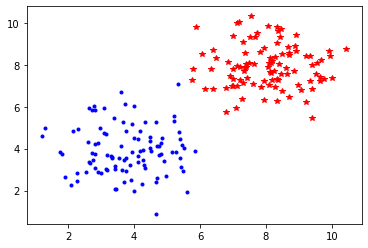

In [6]:
plt.plot(data_a[:,0],data_a[:,1],'b.',data_b[:,0],data_b[:,1],'r*')
plt.show()

In [7]:
data_X = np.zeros((2*N,2))        # 存放样本
data_y = np.zeros(2*N)            # 存放样本对应的类别标签
data_X[:N]    = data_a
data_y[:N]    = 0                 # 类别标签为0
data_X[N:2*N] = data_b   
data_y[N:2*N] = 1                 # 类别标签为1

将样本数据进行“重新洗牌”，打乱样本的顺序

In [8]:
mask = np.arange(2*N)
np.random.shuffle(mask)

In [9]:
X_np = data_X[mask]
y_np = data_y[mask]

In [10]:
X = torch.tensor(X_np).type(torch.FloatTensor)
y = torch.tensor(y_np).type(torch.LongTensor)

## 高级API实现
这里使用pytorch提供的nn.Module搭建模型

### 建模与训练

#### 一层神经网络模型

In [11]:
class LinearClassifier1(nn.Module):
    def __init__(self,n_feature,n_output):
        super(LinearClassifier1,self).__init__()
        self.out = nn.Linear(n_feature,n_output)
    def forward(self,x):
        x = self.out(x)
        return x
net = LinearClassifier1(n_feature=2,n_output=2)
print(net)

LinearClassifier1(
  (out): Linear(in_features=2, out_features=2, bias=True)
)


#### 两层神经网络模型

In [35]:
class LinearClassifier2(nn.Module):
    def __init__(self,n_feature,n_output):
        super(LinearClassifier2,self).__init__()
        self.linear1 = nn.Linear(n_feature,10)
        self.relu1   = nn.ReLU()
        self.out     = nn.Linear(10,n_output)
    def forward(self,x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.out(x)
        return x
net = LinearClassifier2(n_feature=2,n_output=2)
print(net)

LinearClassifier2(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (relu1): ReLU()
  (out): Linear(in_features=10, out_features=2, bias=True)
)


### 训练

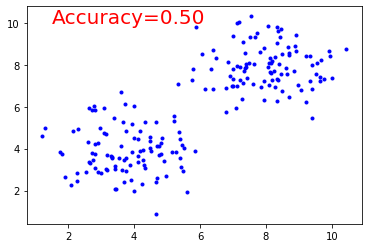

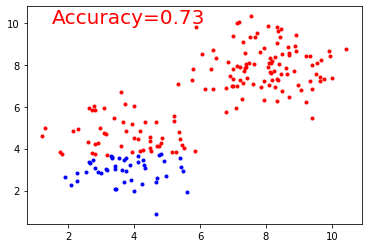

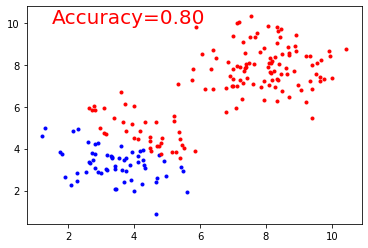

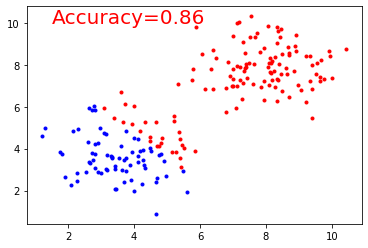

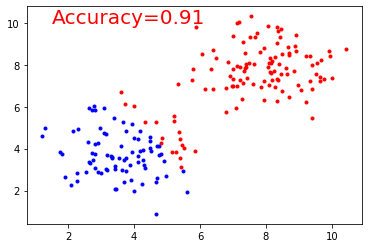

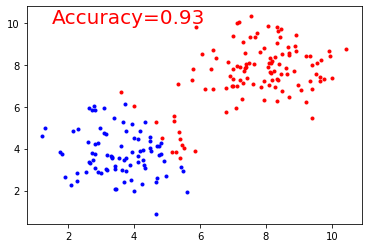

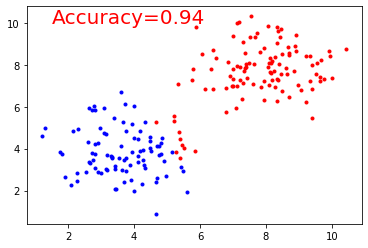

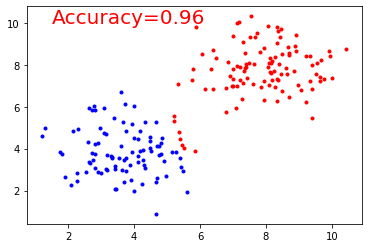

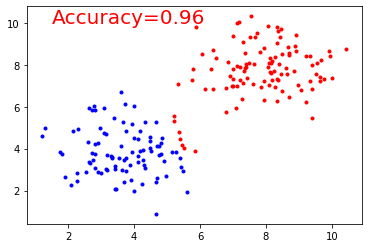

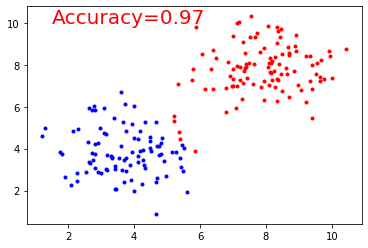

In [12]:
optimizer = torch.optim.SGD(net.parameters(),lr=0.05)
loss_func = nn.CrossEntropyLoss()

for i in range(200):
    out = net(X)
    loss = loss_func(out,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 每10次进行一次画图，将分类结果显示出来
    if i%20 == 0:
        predict = out.argmax(dim=1)
        accuracy = predict.eq(y).sum().item()/len(X)
        #print(predict.size(),y.size())
        #print(accuracy)
        class_a = X[predict==0].data.numpy()   # 归类到a类的样本
        class_b = X[predict==1].data.numpy()   # 归类到b类的样本
        plt.text(1.5,10,'Accuracy=%.2f'%accuracy,fontdict={'size':20,'color':'red'})
        plt.plot(class_a[:,0],class_a[:,1],'b.')
        plt.plot(class_b[:,0],class_b[:,1],'r.')
        #print(class_a.shape,class_b.shape)
        plt.pause(0.1)                        # 当前绘图窗口持续显示0.1s


## 底层API实现
使用pytorch非常底层的关于数学运算的API函数实现

In [81]:
W = torch.randn(2,2,requires_grad=True).type(torch.FloatTensor)
b = torch.randn(2,requires_grad=True).type(torch.FloatTensor)
print(W,b)

tensor([[ 0.8623, -2.6199],
        [-1.0680,  1.0073]], requires_grad=True) tensor([-1.6129,  0.6569], requires_grad=True)


In [83]:
W+b.view(1,-1)

tensor([[-0.7506, -1.9630],
        [-2.6809,  1.6642]], grad_fn=<AddBackward0>)

0 4.056268215179443


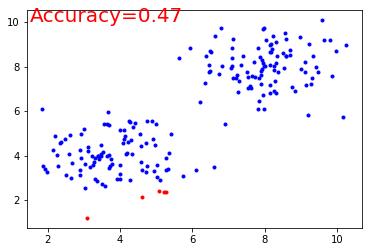

20 0.6752307415008545


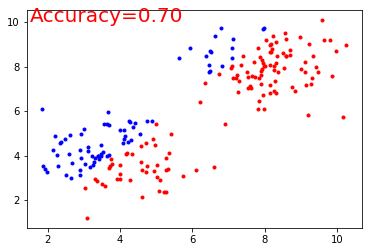

40 0.5203765630722046


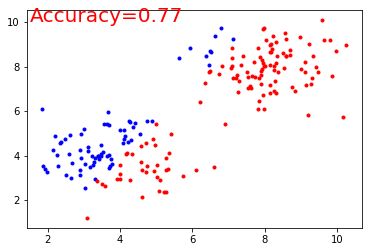

60 0.4286808371543884


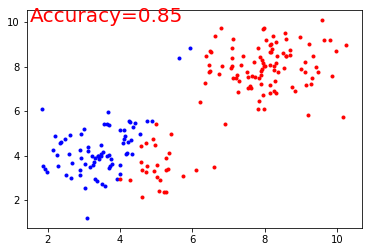

80 0.3766919672489166


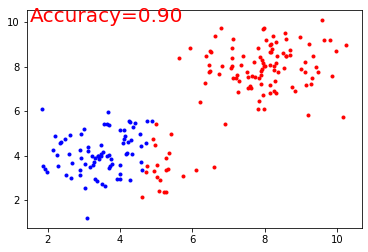

100 0.343077152967453


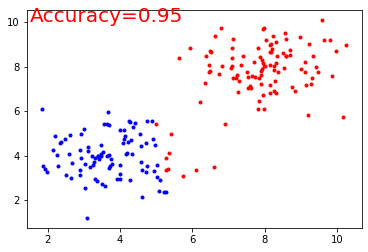

120 0.31765779852867126


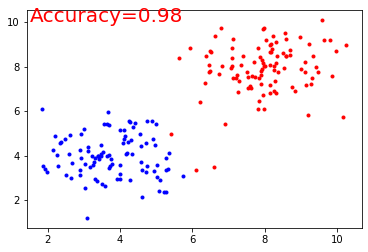

140 0.2965911328792572


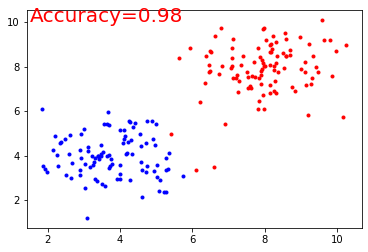

160 0.2784118950366974


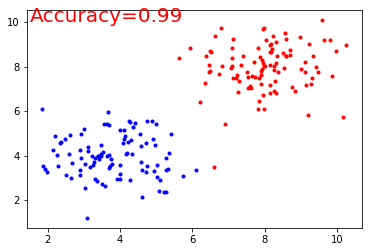

180 0.2624339759349823


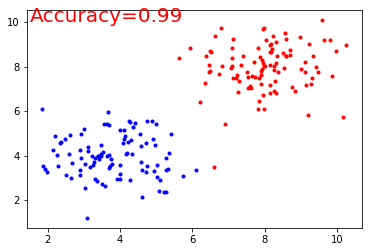

In [80]:
lr = 0.08
loss_func = nn.CrossEntropyLoss()
for i in range(200):
    # forward  score = X*W
    score = X.mm(W) + b
    
    # softmax loss
    #loss = loss_func(score,y)
    score_exp     = torch.exp(score)
    score_correct = score_exp[range(2*N),y]
    loss = -torch.log(score_correct/torch.sum(score_exp,dim=1))
    loss = torch.sum(loss)/(2*N)   

    # backward
    loss.backward()
    #loss.backward(create_graph=True)
    
    # update W
    with torch.no_grad():
        W -= lr*W.grad
        W.grad.zero_()
        b -= lr*b.grad
        b.grad.zero_()
        # plot
        if i%20 == 0:
            print(i, loss.item())
            predict = score.argmax(dim=1)
            accuracy = predict.eq(y).sum().item()/len(X)
            #print(predict.size(),y.size())
            #print(accuracy)
            class_a = X[predict==0].data.numpy()   # 归类到a类的样本
            class_b = X[predict==1].data.numpy()  # 归类到b类的样本
            plt.text(1.5,10,'Accuracy=%.2f'%accuracy,fontdict={'size':20,'color':'red'})
            plt.plot(class_a[:,0],class_a[:,1],'b.')
            plt.plot(class_b[:,0],class_b[:,1],'r.')
            #print(class_a.shape,class_b.shape)
            plt.pause(0.1)                        # 当前绘图窗口持续显示0.1s